# Citation Needed? Automatically Detecting Sentences from Computing Research Papers that Need Citations
Author: Nicholas Vincent, Northwestern University

email: nickvincent@u.northwestern.edu (typos, comments, and concerns welcome)

web: [www.nickmvincent.com](http://www.nickmvincent.com)

Prof. Doug Downey's EECS349 course, final project

Code for this project: https://github.com/nickmvincent/where_that_from

## Abstract: 
The scientific paper is the primary artifact produced by scientists of every discipline. Within a scientific paper, citations are incredibly valuable: they help connect a paper to the surrounding literature, provide evidence for claims, and empower a single PDF (often with less than 10 pages) to “stand on the shoulders of giants” (as Isaac Newton put it) by referencing prior work. However, language is ambiguous, and it may not always be trivial to decide whether a certain sentence should include a citation or not.  Therefore, it may be valuable for an author or reviewer to be able to quickly identify whether a sentence should include a citation or not, or better yet to get a list of sentences that are worthy of deeper inspection. We implement and test a variety of machine learning classifiers that attempt to solve the task of identifying whether or not a given sentence should include a citation.

In this document, we report our results for a variety of approaches, falling into two broad categories: (1) using word count vectorization alongside textual metadata with traditional classification techniques (Naive Bayes, Decision Trees, Logistic Regression, etc.) and (2) using deep learning techniques. Using a dataset with 6022 examples (14.8% positive), we see that logistic regression and support vector machine approaches provide a good balance of performance and quick training. Finally, using a larger dataset with 32,228 examples (12.4% positive), we are able to train a classifer with 75% recall and 38.5% precision (AUROC is 87.8% and accuracy is 89%). This performance should be adequate to make this classifier useful as a "machine assistant" for authors or reviewers of academic papers.

## About this Notebook
This document was produced by converting a Jupyter notebook (titled "report", in the Github repo) to HTML. Figures are included along with the code used to generate them.

The main content of this notebook is organized based on the project guidelines for EECS349.

The following sections are:
1. Methods: Dataset
2. Methods: Overview of Features and Classification Approaches
3. Results
4. Future Work

An appendix is included in the [Github repository](https://github.com/nickmvincent/where_that_from), as a notebook titled "Appendix". This appendix is still in-progress. While not part of the official project submission, the appendix includes a variety of minor details that may be interesting and helpful (or not) to readers.

In addition to using the Jupyter project, we also heavily used pandas, seaborn, and matplotlib in preparing this report.

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('talk')

## Methods: Dataset
#### Data Aquisition
We generated all training and test data by downloading computing papers as PDF files and converting them to text (detailed in the Appendix and the code itself). Each text file was processed so as to split the text into sentences, identify all the sentences with citations, and then strip out the evidence of the citations (e.g. bracketed numbers like "[1]") so the data could be used fairly for training. The full data pre-processing steps are explained in the Appendix.

First we used a small dataset composed of 21 papers. This dataset included 6022 different sentences and 14.8% had citations. The papers for this dataset came exclusively from the PSA Research Group (the author's research lab), so we use this data when referring to example sentences. We refer to this dataset as the `psa_research` dataset. This is the dataset we did most of experiments with.

The second dataset was produced by downloading the full Proceedings of the 2018 CHI Conference on Human Factors in Computing Systems (CHI 2018), made available through the [ACM Digital Library](https://dl.acm.org/citation.cfm?id=3173574). From this set of over 600 papers, we used the first 100 papers, which allowed the full training and testing process to be performed on a single laptop. In total, this dataset has 32,228 examples (12.4% positive). This is the dataset we used for selecting a "best" model.


## Methods: Overview of Features and Classification Approaches Used

### Initial Approach: Tf-Idf and Sklearn
For our first set of classification approaches, we followed a simple strategy to turn sentences into features. We vectorized each sentence using a term frequency-inverse document frequency (Tf-Idf) approach, and then computed additional "hand-crafted" features to account for some aspects of text that are not captured by word counting: number of characters in the sentence and boolean variables indicating whether each sentence has any digit characters, has a comma character, has a quote character, and has an uppercase character after the first character.

Tf-Idf details: For the large dataset, we limited the bag-of-words vocabulary size to the 10,000 most frequent words to avoid memory issues. For all datasets, we included stop-words (as removing them just lowered performance) and stripped accents.

Then, we performed a variety of runs with statistical feature selection to reduce dimensionality of our feature space (sklearn's SelectKBest with ANOVA F-value, see [sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif). We tried reducing the max number of features to:
50, 100, 500, 1000, 2000, 3000, 4000, and 5000.

Using these sets of features, we tested a variety of classifiers (using sklearn implementations, with default parameters unless otherwise noted).
1. Logistic Regression (using C Values of 0.1, 1, 10, and 100) - referred to as `logistic`
2. Linear Support Vector Classifier (using C values of 0.1, 1, 10, and 100) - referred to as `linearsvc` or `SVM`
3. Decision Tree - referred to as `tree`
4. Gaussian Naive Bayes - referred to as `GaussianNb`
5. K-Nearest Neighbors (3 neighbors) - referred to as `3nn`
6. Select No Sentences - as a baseline, we include a classifer that never selects any sentences (i.e. it always choose negative label) - referred to as `SelectNoSentences`

### Deep Learning
We tested two different deep learning approaches for classification as well. Both were implemented using Tensorflow.

First, we tried to use a character-level RNN trained for language modeling to perform classifications by adding our labels as tokens at the end of the sentence (e.g. "This is negative example.\`\`0  And this is a positive examples.\`\`1" ) and predicting a single character following each sentence. The code for this implementation was a modified fork of this MIT-licensed [Github repo](https://github.com/crazydonkey200/tensorflow-char-rnn). This approach was a bit of a hack (turning a language model into a classifier without changing the actual network or training). The fork lives [here](https://github.com/nickmvincent/tensorflow-char-rnn).

Second, we trained a simple neural network using Tensorflow's DNNClassifier Estimator. For this classifier, we used the 250-dimension Wiki-word word embeddings, which are pre-trained on the Wikipedia corpus and available with Tensorflow. We tried a few network architectures with 1, 2, and 3 hidden layers. The reported results used 2 hidden layers, with 250 units then 100 units, with dropout probability of 0.1. The code for this implementation was a modified version of a CC-3.0 tutorial in the [Tensorflow docs](https://www.tensorflow.org/tutorials/text_classification_with_tf_hub). This model is referred to as `DNN`.

### A note on software and hardware used
As mentioned above, all our deep learning implementations used Tensorflow and all other machine learning implementations used sklearn. While we used multiple machines (including Google Cloud Platform) throughout experiments, all our reported results were run from the same machine, a Dell XPS 13 64-bit Windows machine with Intel i7-6560U CPU @ 2.20 GHZ and no GPU. This allowed us to directly compare the time taken of various methods.

## Results
### Metrics and other Considerations
For all our experiments, we decided to focus on performance metrics beyond accuracy, especially given the imbalanced class labels. Specifically, we chose to use Area Under the Receiver Operator Characteristic curve (AUROC) when initially comparing models with the small dataset (as we were interested in having a model with strong discriminative power), and then to focus on the precision-recall curves for the large dataset to try to achieve a good precision-recall balance for users. The use case we considered was an academic who is writing a paper or reviewing a paper and wants to quickly use our tool to check for any sentences that might need citations. Under this assumption, the user likely wants to emphasize recall over precision: because most sentences do not have citations, if the model identifies all the sentences that do have citations, the user can quickly eliminate the false positives with their human judgment. Therefore, we decided to aim for a model that had good precision when recall was over 75%.

Given that academics are often very busy, come from a variety of different fields and disciplines, often like to run their own software, and often work with limited computing resources, we also wanted to emphasize models that train quickly, test quickly, and run on a laptop, so that users could realistically train their own personal model. That being said, we still did consider the performance of slower and costlier approaches (e.g. deep learning, nearest neighbors) in case performance was vastly improved.

All our results come from 5-fold cross validation. The full set of results for each dataset, including standard deviation across folds, is available in the `results` directory in the repository.

### Comparing model performance for the `psa_research` dataset
We were unable to get a language modeling, small (2 hidden layers), character-level RNN or LSTM model to discriminate between sentences types - typically the AUROC was around 0.5. Additionally, given the comparatively slow training times (about 4 minutes per epoch for LSTM) *and* slow testing times (1.5 minutes to evaluate 20% of the small dataset), we decided to remove this model from contention.

Below, the 3 stacked heatmaps in Figure 1 show the AUROC, accuracy, and 5-fold cross validation time (i.e. the time it might take a potential user to check their model) for each of our experiments on the smaller `psa_research` dataset. In Figure 2, the best accuracy and AUROC for each type of model is shown. We found that SVM, logistic regression, DNN, and Naive Bayes all provided good accuracy, but SVM and logistic regression provided the best AUROC. Based on these results, we focused on SVM and logistic regression when examing precision-recall curves for the larger `chi_2018` dataset.

In [77]:
# Load the results in for plotting
df = pd.read_csv('results/psa_research/result_dataframe.csv')
dnn_df = pd.concat([pd.read_csv('results/psa_research/dnn_best_roc_auc.csv'), pd.read_csv('results/psa_research/dnn_best_accuracy.csv')])
dnn_df['time'] = dnn_df['time'] * 5 # DNN dataframe has time per fold, we want time per 5 folds
df = pd.concat([df, dnn_df])

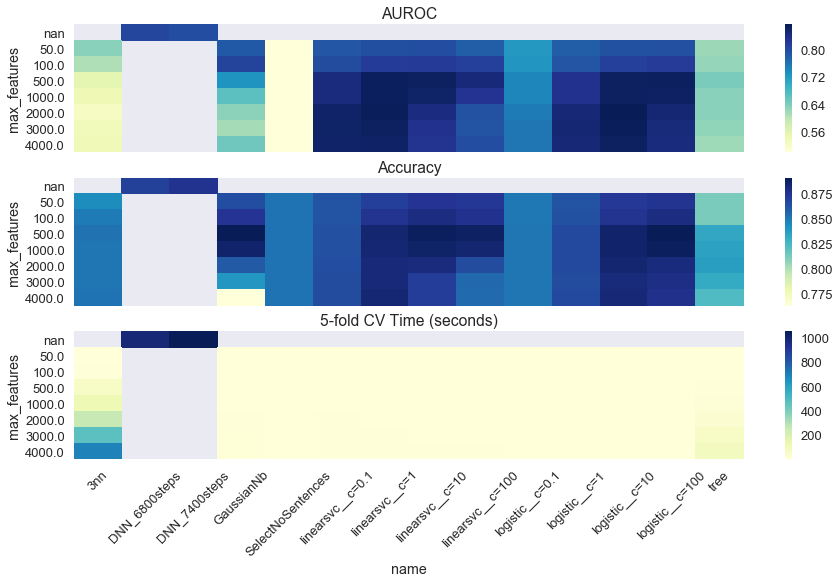

In [78]:
_, axes = plt.subplots(nrows=3, figsize=(15,8))
ax = sns.heatmap(df.pivot('max_features', 'name', 'roc_auc'), ax=axes[0], cmap="YlGnBu")
ax.set_title('AUROC')
ax.get_xaxis().set_visible(False)
ax = sns.heatmap(df.pivot('max_features', 'name', 'accuracy'), ax=axes[1], cmap="YlGnBu")
ax.set_title('Accuracy')
ax.get_xaxis().set_visible(False)
ax = sns.heatmap(df.pivot('max_features', 'name', 'time'), ax=axes[2], cmap="YlGnBu")
ax.set_title('5-fold CV Time (seconds)')
plt.xticks(rotation=45)
plt.show()

_Figure 1_ - AUROC (top), Accuracy (middle), and 5-fold cross validation time in seconds (bottom) are shown for our experimental runs. Across the y-axis, number of max features varies. Across the x-axis, model type varies (including hyperparameters like number of training steps for `DNN` and C_val for `logistic` and `linearsvc` models).

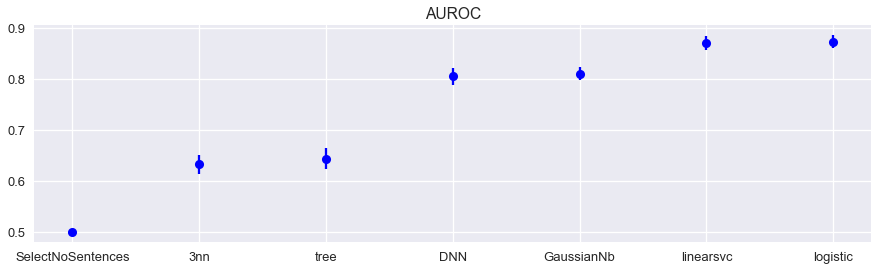

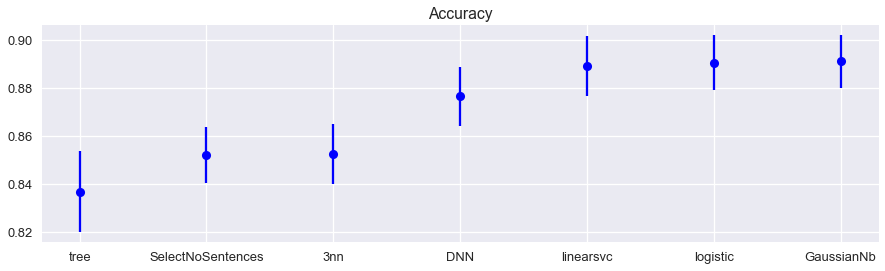

In [ ]:
for score in ['roc_auc', 'accuracy']:
    algo_name_to_max = {}
    algo_name_to_std = {}
    for algo_name in list(set(df.algo_name)):
        algo_name_to_max[algo_name] = df[df.algo_name == algo_name][score].max()
        algo_name_to_std[algo_name] = df[score + '_std'].iloc[df[df.algo_name == algo_name][score].idxmax()]
    x, y = zip(*sorted(algo_name_to_max.items(), key=lambda t: t[1]))
    yerr = [algo_name_to_std[key] for key in x] # get standard deviations into an appropriately ordered list
    plt.figure(figsize=(15,4))
    plt.errorbar(range(len(y)), y, yerr=yerr, fmt='bo') # show standard deviation
    plt.xticks(range(len(y)), x)
    plt.title('AUROC' if score == 'roc_auc' else 'Accuracy')
plt.show()

_Figure 2_ - The best AUROC (top) and Accuracy (bottom) for each type of model is shown. Error bars show standard deviation.

### Precision-recall with the `chi_2018` dataset
Focusing on logstic regression and SVM for the larger `chi_2018` dataset, we found a variety of hyperparameter choices achieved "useable" performance. Figure 3 (below) shows precision-recall curves for our experiments on this larger dataset. Qualitatively, we see that logistic regression and SVM both provide reasonable precision-recall balance using C around 10-100 and around 1000-3000 features. Finally, we see that the "best" model, logistic regression with C of 10 and 3000 features achieved 0.878 AUROC and get 0.385 precision at 0.75 recall. In other words, users can expect a classifier with class weights set appropriately to identify 75% of all the sentences that might need citations and and little more than 6 of 10 will be erroneous. This performance should be adequate to help authors and reviewers without causing the user to lose more time than might gain from using the tool. Additionally, given their personal workflow, the user could choose to re-train to the model to emphasize precision or recall as desired and use these curves as guidelines.

In [ ]:
sns.set() # can't have big text for this plot
pr_df = pd.read_csv('results/chi_2018/precision_recall_dataframe.csv')
g = sns.FacetGrid(
    data=pr_df[(pr_df.algo_name == 'logistic') | (pr_df.algo_name == 'linearsvc')], # don't want to show SelectNoSentences
    row='algo_name', col='C_val', hue='max_features',
)
g = (g.map(plt.plot, 'recall', 'precision').add_legend())
plt.show()

_Figure 3_: Precision-recall curves for logistic and SVM classifiers on the `chi_2018` dataset. Precision is shown on the y-axis and recall on the x-axis. Color denotes different choices for number of features to use, and each column shows a different choice of model parameter C.

In [ ]:
# Show the "best" model performance in a nicely formatted sentence
df = pd.read_csv('results/chi_2018/result_dataframe.csv')
row = df.iloc[df.roc_auc.idxmax()]
print(
    """
    "Best" model:
    A {} model with {} features and a C_val of {}
    gets an AUROC of {} (standard deviation: {}) 
    and an accuracy of {} (standard deviation: {}) 
    after training for {} seconds.
    """.format(
    row.algo_name, row.max_features, row.C_val, round(row.roc_auc,3), round(row.roc_auc_std,3), 
    round(row.accuracy,3), round(row.accuracy_std,3), row.time)
)

## Future Work
While we focused on testing models that were small and quick to train, an interesting next step would be to try to build an extremely general model, incorporating text from across academic disciplines. This would require substantially more infrastructure and resources. It would be interesting to see how deep learning methods compare to other methods when using orders of magnitude more data (and, by extension less similar data).

Additionally, if user tests suggest that performance of our classifers are unsatisfactory, it may be possible to tweak our implementation to improve overall performance, perhaps through additional hand-crafted features designed by academics familiar with a particular field's writing trends, or through a more comprehensive hyperparameter search. In particular, although our exploration of deep learning approaches did not prove fruitful, future work could explore different network structures and more exhaustive hyperparameter search (e.g. adding layers, trying different dropout values, chaining networks).